In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import networkx as nx
import numpy as np
from pyvis.network import Network
import pyvis as vis
import random
import math
import sklearn.metrics
from matplotlib.pyplot import figure
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import igraph as ig

In [3]:
class MCS_classification:
    """
    A class used for most common subgraph classification

    ...



    Methods
    -------
    calculate_most_common_subgraphs(self,source,graphs_to_compare)
        creates a list of all most common subgraphs for all patients
    LOOCV_classification(self)
        adds all predictions for patients to a list
    get_diagnosis(self,similar_nodes_edges)
        gets the value for the most common subgraph 
    Most_Common_Subgraph(self,source,graph_2)
        calculates the most common subgraph value based on the metric
    accuracy(self,predictions)
        calculates the accuracy of the model
    plot_confusion_matrix(self)
        plots the confusion matrix
    metrics_overview(self)
        print metrics
    all_paths_from_source(self,G)
        calculates the sum of all edges
    """
    
    def __init__(self,df,tuples,labels,metric,predictions=None):
        
        """
    Parameters
    ----------
    df : pandas.DataFrame
        a dataframe of the graphs and corresponding labels
    tuples : list(tuples)
        list of tuples (graph,label)
    labels : list
        Labels of the patients
    metric : str
        string with the metric name
        
        
        
        """
        self.df = df
        self.tuples = tuples
        self.labels = labels
        self.metric = metric
        
        
    def calculate_most_common_subgraphs(self,source,graphs_to_compare):
    
        """Calculate all other mcs for a given graph.

        Parameters
        ----------
        source : networkx.classes.multidigraph.MultiDiGraph
            The first networkx graph
        graphs_to_compare : list(networkx.classes.multidigraph.MultiDiGraph)
            list of networkx graphs

        Returns
        -------
        list(networkx.classes.multidigraph.MultiDiGraph)
            list of networkx most common subgraphs
        """
        mcs_list = []
        for g in range(0,len(graphs_to_compare)):
            mcs_list.append(self.Most_Common_Subgraph(source, graphs_to_compare.loc[g][0]))
        return mcs_list
        
    def LOOCV_classification(self):
       
        """Add all genetic disorder predictions for all patients to a list.
    
        Returns
        -------
        float
            The accuracy for the model
        """
        disorder_prediction = []
        
        for p in range(0,len(self.df['graphs'])):
            graph_comparisons_patient_p = self.calculate_most_common_subgraphs(self.df.loc[p][0], self.df)
            graph_comparisons_patient_p[p] = -100000 
            disorder_prediction.append(self.get_diagnosis(graph_comparisons_patient_p))
        self.predictions = disorder_prediction
        return self.accuracy(disorder_prediction)
    


    def get_diagnosis(self,similar_nodes_edges):
        """Calculate all other mcs for a given graph.

        Parameters
        ----------
        similar_nodes_edges : int
            The number of the metric


        Returns
        -------
        str
            The predicted genetic disorder
        """
        
        return self.tuples[similar_nodes_edges.index(max(similar_nodes_edges))][1]


    def Most_Common_Subgraph(self,source,graph_2):
        """Calculate a mcs between a source graph and a graph_2.

        Parameters
        ----------
        source : networkx.classes.multidigraph.MultiDiGraph
            networkx graph
        graph_2 : networkx.classes.multidigraph.MultiDiGraph
            networkx graph


        Returns
        -------
        int
            The value from the mcs based on the metric
        """
    
        mcs = nx.DiGraph()
    
        # Add the edges that occur in both graphs to the mcs_graph
        for node_a,node_b in graph_2.edges(): 
        
            if source.has_edge(node_a, node_b): #Check if the out-edge between node_a and node_b 
                                            #also exists in graph 1.
            
                mcs.add_edge(node_a, node_b) # Add edge to the mcs_graph between nodes 
                                          #in which both graph 1 and 2 have an edge.
        if self.metric == "nodes with penalty":
            return ((len(mcs.nodes())) / ((len(source.nodes()))+(len(graph_2.nodes()))))
        if self.metric == "edges":
            return len(mcs.edges())
        if self.metric == "nodes":
            return len(mcs.nodes())
        if self.metric == "weights":
            sum_of_weights = mcs.size(weight="weight")
            return sum_of_weights
        
        return print("Wrong input metric")
    
    
    def accuracy(self,predictions):
        """Returns the accuracy of the model

        Parameters
        ----------
        predictions : list
            list of predicted genetic disorders for the patients
        Returns
        -------
        int
            The accuracy
        """
        list_common = []
        for a, b in zip(self.labels, predictions):
            if a == b:
                list_common.append(a)
        return len(list_common)/len(predictions)
    
    def plot_confusion_matrix(self):
        """Plots the confusion matrix
        
        Returns
        -------
        plot
            plots the confusion matrix
        """
        plt.rcParams.update(plt.rcParamsDefault)

        plt.rcParams['figure.figsize'] = [10, 10]
        plt.rcParams['font.size'] = 8
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions(self.labels,self.predictions)

        plt.show()
        
        
    def metrics_overview(self):
        """Prints metrics
        """
        edges_confusion_matrix = sklearn.metrics.confusion_matrix(self.labels,self.predictions)

        FP = edges_confusion_matrix.sum(axis=0) - np.diag(edges_confusion_matrix)  
        print('FP',FP)
        FN = edges_confusion_matrix.sum(axis=1) - np.diag(edges_confusion_matrix)
        print('FN',FN)
        TP = np.diag(edges_confusion_matrix)
        print('TP',TP)
        TN = edges_confusion_matrix.sum() - (FP + FN + TP)
        print('TN',TN)
        print('_______________________________')
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        print('TPR',TPR)
        print('Average TPR',np.average(TPR))
        print('_______________________________')
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        print('TNR',TNR)
        print('Average TNR',np.average(TNR))
        print('_______________________________')

        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        print('PPV',PPV)
        print('Average PPV',np.average(PPV))
        print('_______________________________')

        # Negative predictive value
        NPV = TN/(TN+FN)
        print('NPV',NPV)
        print('Average NPV',np.average(NPV))
        print('_______________________________')

        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        print('FPR',FPR)
        print('Average FPR',np.average(FPR))
        print('_______________________________')

        # False negative rate
        FNR = FN/(TP+FN)
        print('FNR',FNR)
        print('Average FNR',np.average(FNR))
        print('_______________________________')

        # False discovery rate
        FDR = FP/(TP+FP)
        print('FDR',FDR)
        print('Average FDR',np.average(FDR))
        print('_______________________________')

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        print('ACC',ACC)
        print('Average ACC',np.average(ACC))
        print('_______________________________')

        F1 = 2*((PPV*TPR)/(PPV+TPR))
        F1 = F1[~np.isnan(F1)]
        print('F1',F1)
        print('Average F1',np.average(F1))
        print('_______________________________')
        print((FP+FN)/(TP+FP+FN+TN))

In [5]:
def add_weights_edges(graph):
    """Adds edge weights to graph. The weight for an edge is equal to the distance from the node to the 'All' node in the HPO graphs

    Parameters
    ----------
    graph : networkx.classes.multidigraph.MultiDiGraph
        a networkx graph

    Returns
    -------
    networkx.classes.multidigraph.MultiDiGraph
        a networkx graph where edge weights were just added
    """
    G = nx.DiGraph(graph)
    for u,v,d in G.edges(data=True):
        l1 = list((nx.all_simple_paths(G,u, 'All')))
        path_to_source_length = len([item for sublist in l1 for item in sublist])
            
        G[u][v]['weight'] = ((path_to_source_length/(len(l1)))-1)
            
    return G

In [6]:
def add_weights_graphs(list_graphs):
    """Adds graphs with edge weights to a list of graphs.

    Parameters
    ----------
    list_graphs : list(networkx.classes.multidigraph.MultiDiGraph)
        list of networkx graphs

    Returns
    -------
    list(networkx.classes.multidigraph.MultiDiGraph)
        list of networkx graphs
    """
    graphs = []
    for i in range(0,len(list_graphs)):
        gn =add_weights_edges(list_graphs[i])
        graphs.append(gn)
    return graphs

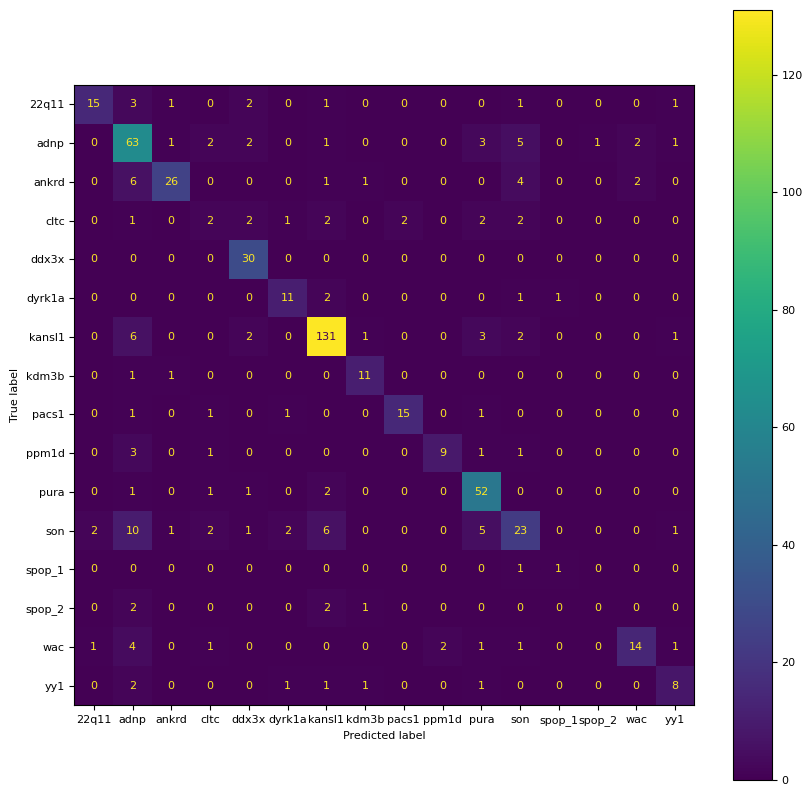

0.7432188065099458


In [10]:
patients = pd.read_pickle('C:/Users/niels/Downloads/patienten.pkl') #Read the dataframe of the patients
graphs_weights = add_weights_graphs(patients['graphs'])
tuple_graphs_labels_weights = list(zip(graphs_weights,patients['label'])) #Convert the dataframe to tuples of (graph,label) for the patients
sorted_graphs_weights = pd.DataFrame (tuple_graphs_labels, columns = ['graphs','genetic disorder']) #Create a dataframe with a column for the graphs of the patients and another column with the labels of the patients
#Check nodes,edges,weights,nodes with penalty


#Initialize class instance
mcs1 = MCS_classification(sorted_graphs_weights,tuple_graphs_labels_weights,labels,"nodes with penalty")

#Leave-one-out cross validation classification based on mcs classification with nodes with penalty metric.
acc = mcs1.LOOCV_classification()

#Plot the confusion matrix
mcs1.plot_confusion_matrix()
print(acc)

In [11]:
#Plot some confusion matrix metrics
mcs1.metrics_overview()

FP [ 3 40  4  8 10  5 18  4  2  2 17 18  1  1  4  5]
FN [ 9 18 14 12  0  4 15  2  4  6  5 30  1  5 11  6]
TP [ 15  63  26   2  30  11 131  11  15   9  52  23   1   0  14   8]
TN [526 432 509 531 513 533 389 536 532 536 479 482 550 547 524 534]
_______________________________
TPR [0.625      0.77777778 0.65       0.14285714 1.         0.73333333
 0.89726027 0.84615385 0.78947368 0.6        0.9122807  0.43396226
 0.5        0.         0.56       0.57142857]
Average TPR 0.6274704747274455
_______________________________
TNR [0.99432892 0.91525424 0.99220273 0.9851577  0.98087954 0.99070632
 0.95577396 0.99259259 0.99625468 0.99628253 0.96572581 0.964
 0.99818512 0.99817518 0.99242424 0.99072356]
Average TNR 0.9817916949034906
_______________________________
PPV [0.83333333 0.61165049 0.86666667 0.2        0.75       0.6875
 0.87919463 0.73333333 0.88235294 0.81818182 0.75362319 0.56097561
 0.5        0.         0.77777778 0.61538462]
Average PPV 0.6543734000203304
________________________

C:\Users\niels\AppData\Local\Temp/ipykernel_12364/3585243920.py:248: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2*((PPV*TPR)/(PPV+TPR))
